In [405]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from pprint import pprint as pp 
from xgboost import XGBRegressor



In [2]:
# import chardet
# with open('EM-DATA-all.csv', 'rb') as f:
#     result = chardet.detect(f.read())  #
# result

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}

In [406]:
!ls


(base) C:\Users\work-02\Documents\git\BootlegForPeace>dir   
 Volume in drive C is OS
 Volume Serial Number is 6CCF-598B

 Directory of C:\Users\work-02\Documents\git\BootlegForPeace

18-Nov-18  02:58 AM    <DIR>          .
18-Nov-18  02:58 AM    <DIR>          ..
18-Nov-18  01:15 AM    <DIR>          .ipynb_checkpoints
17-Nov-18  11:18 PM    <DIR>          .ipynb_checkpoints.old
18-Nov-18  01:15 AM    <DIR>          data
14-Nov-18  10:11 PM         1,762,056 EM-DATA-all.csv
14-Nov-18  10:01 PM         1,762,075 EM-DATA-all.txt
18-Nov-18  01:15 AM            85,207 feature-extend.ipynb
10-Nov-18  05:06 AM         1,823,296 GPCC_DI_201810.nc
18-Nov-18  02:58 AM           198,694 hfg_eda.ipynb
14-Nov-18  10:22 PM        23,503,911 INFORM2019_TREND_2009_2019_v035_ALL_v2.csv
14-Nov-18  10:21 PM         9,827,132 INFORM2019_TREND_2009_2019_v035_ALL_v2.xlsx
17-Nov-18  03:17 PM               556 meeting notes.txt
18-Sep-07  06:03 PM        51,710,444 pdsi.monthly.maps.1870-2005.fawc=1.r2.5x2

In [407]:
# import the dataset(s)
emdat = pd.read_csv('EM-DATA-all.csv', encoding='Windows-1252')
inform = pd.read_csv('INFORM2019_TREND_2009_2019_v035_ALL_v2.csv')
inform.columns

Index(['ISO', 'IndicatorId', 'IndicatorName', 'IndicatorScore',
       'IndicatorType', 'INFORMYear', 'DataYear'],
      dtype='object')

In [408]:
# pp(inform.sort_values('ISO').ISO.unique())
# emdat.sort_values('iso').iso.unique()

# Start here

In [37]:
# import refugee data
rdf = pd.read_csv('data/refugee_monthly.csv')
rdf.info()
rdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332189 entries, 0 to 332188
Data columns (total 5 columns):
Country / territory of asylum/residence    332189 non-null object
Origin                                     332189 non-null object
Year                                       332189 non-null int64
Month                                      332189 non-null object
Value                                      332189 non-null object
dtypes: int64(1), object(4)
memory usage: 12.7+ MB


,Country / territory of asylum/residence,Origin,Year,Month,Value
0,Australia,Afghanistan,1999,January,8
1,Australia,Afghanistan,1999,February,10
2,Australia,Afghanistan,1999,March,25
3,Australia,Afghanistan,1999,April,25
4,Australia,Afghanistan,1999,May,7


In [38]:
rdf.columns = ['Country', 'Origin', 'Year', 'Month', 'Value']
greece = rdf[rdf.Country == 'Greece']
tur = rdf[rdf.Country == 'Turkey']
ger = rdf[rdf.Country == 'Germany']
greece.head()

,Country,Origin,Year,Month,Value
6865,Greece,Afghanistan,1999,January,12
6866,Greece,Afghanistan,1999,February,9
6867,Greece,Afghanistan,1999,April,2
6868,Greece,Afghanistan,1999,May,27
6869,Greece,Afghanistan,1999,July,4


In [39]:
greece.Country.iloc[0]

'Greece'

In [40]:
def count_migrants():
    month_mapping = {'January':1, 'February':2, 'April':3, 'May':4, 'July':5, 'August':6,'September':7, 'October':8, 'November':9, 'June':10, 'March':11, 'December': 12}
    res = []
    for cnt in rdf.Country.unique():
        asylum = rdf[rdf.Country == cnt]
        asylum.Month = asylum.Month.map(month_mapping)
        asylum.Value = asylum.Value.replace('*', 2)
        asylum.Value = asylum.Value.astype(int)
        aslmgrp = asylum[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
        aslmgrp['Country'] = asylum.Country.iloc[0]
        aslmgrp = aslmgrp[:-1]
        if len(aslmgrp) > 195:
            res.append(aslmgrp)
    return res
migrants = count_migrants()[:-2]

In [41]:
pp(len(migrants)) 
for i in migrants:
    print(len(i))
    print(i.head(n=1))

29
220
   Year  Month  Value    Country
0  1999      1    574  Australia
220
   Year  Month  Value  Country
0  1999      1   1366  Austria
220
   Year  Month  Value  Country
0  1999      1   1956  Belgium
220
   Year  Month  Value   Country
0  1999      1     81  Bulgaria
220
   Year  Month  Value Country
0  1999      1   2209  Canada
220
   Year  Month  Value     Country
0  1999      1    602  Czech Rep.
220
   Year  Month  Value  Country
0  1999      1    675  Denmark
215
   Year  Month  Value  Country
0  1999      1    101  Finland
219
   Year  Month  Value Country
0  1999      1   1760  France
220
   Year  Month  Value  Country
0  1999      1   8216  Germany
208
   Year  Month  Value Country
0  1999      1    167  Greece
217
   Year  Month  Value  Country
0  1999      1    907  Hungary
218
   Year  Month  Value  Country
0  1999      1    234  Ireland
200
   Year  Month  Value        Country
0  1999      1     73  Liechtenstein
219
   Year  Month  Value     Country
0  1999      1   

In [42]:
month_mapping = {'January':1, 'February':2, 'April':3, 'May':4, 'July':5, 'August':6,'September':7, 'October':8, 'November':9, 'June':10, 'March':11, 'December': 12}
greece.Month = greece.Month.map(month_mapping)
tur.Month = tur.Month.map(month_mapping)
ger.Month = ger.Month.map(month_mapping)
greece.head()

,Country,Origin,Year,Month,Value
6865,Greece,Afghanistan,1999,1,12
6866,Greece,Afghanistan,1999,2,9
6867,Greece,Afghanistan,1999,3,2
6868,Greece,Afghanistan,1999,4,27
6869,Greece,Afghanistan,1999,5,4


In [43]:
# split df into multiple dfs
# splits = []
# for cntr in greece.Origin.unique():
#     splits.append(greece[greece.Origin == cntr])

# for i in range(len(splits)):
#     pp('{} {}'.format(len(splits[i])))
# # len(splits)

In [27]:
greece.Value = greece.Value.replace('*', 2)
greece.Value = greece.Value.astype(int)
tur.Value = tur.Value.replace('*', 2)
tur.Value = tur.Value.astype(int)
ger.Value = ger.Value.replace('*', 2)
ger.Value = ger.Value.astype(int)

In [28]:
grcgrp = greece[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
turgrp = tur[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
gergrp = ger[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
# pp(gergrp.Value.sum())

# trimming
grcgrp = grcgrp[:-1]
turgrp = turgrp[:-1]
gergrp = gergrp[:-1]

data = [grcgrp, turgrp, gergrp]

In [29]:
# Mitnaka
# irq = rdf[rdf.Origin == 'Iraq']
# irq.Month = irq.Month.map(month_mapping)
# irq.Value = irq.Value.replace('*', 2)
# irq.Value = irq.Value.astype(int)
# irqext = irq[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
# zub = grcgrp
# zub['Irq'] = irqext.Value
# zub

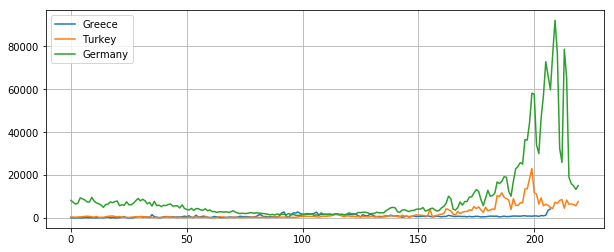

In [30]:
plt.rcParams['figure.figsize'] = [10, 4]
plt.plot(grcgrp.Value.tolist(), label = 'Greece')
plt.plot(turgrp.Value.tolist(), label = 'Turkey')
plt.plot(gergrp.Value.tolist(), label = 'Germany')
plt.legend()
plt.grid()

## Forecasting

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# window_size = 1
# y = grcgrp.Value[window_size:]
# # pp(y.head())
# pp(y.head())
# X = grcgrp.Value.shift(window_size)[window_size:]
# X = [[i] for i in X.tolist()]
# grcgrp.Value.shift(window_size)

In [33]:
def create_features(list_of_df, wndw=5, min_max=False):
    res = []
    for df in list_of_df:
        X = df
        for i in range(1, wndw):
            X['t-'+str(i)] = X.Value.shift(i)
        X = X[wndw-1:]
        y = X.Value
        X = X.drop(['Year','Month','Value'], axis=1)
        if 'Country' in X.columns:
            X = X.drop(['Country'], axis=1)
        if min_max:
            X['min'] = min(y)
            X['max'] = max(y)
#         X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=12)
#         res.append(train_test_split(X, y, shuffle=False, test_size=12))
        res.append((X,y))
    return res

# create_features(data)

In [34]:
def heavy_hitter(hhs):
    # Mitnaka
    irq = rdf[rdf.Origin == 'Iraq']
    irq.Month = irq.Month.map(month_mapping)
    irq.Value = irq.Value.replace('*', 2)
    irq.Value = irq.Value.astype(int)
    irqext = irq[['Year','Month','Value']].groupby(['Year','Month'], as_index=False).sum()
    pp(irq.head())
    return 0
heavy_hitter([])

       Country Origin  Year  Month  Value
272  Australia   Iraq  1999      1     33
273  Australia   Iraq  1999      2     48
274  Australia   Iraq  1999     11     42
275  Australia   Iraq  1999      3     55
276  Australia   Iraq  1999      4     42


0

In [35]:
# turkey_heavy_hitters = ['Iraq', 'Afghanistan', 'Iran (Islamic Rep. of)', 'Somalia', 'Syrian Arab Rep.', 'Pakistan', 
#                         'Palestinian', 'Uzbekistan', 'Sudan', 'Uganda']
# turgrp[['Year', 'Month', 'Value']]


In [36]:
migrants[5]

,Year,Month,Value,Country
0,1999,1,602,Czech Rep.
1,1999,2,429,Czech Rep.
2,1999,3,568,Czech Rep.
3,1999,4,603,Czech Rep.
4,1999,5,610,Czech Rep.
5,1999,6,582,Czech Rep.
6,1999,7,699,Czech Rep.
7,1999,8,553,Czech Rep.
8,1999,9,723,Czech Rep.
9,1999,10,536,Czech Rep.


In [438]:
# y = X.Value
# X = X.drop(['Year','Month','Value'], axis=1)
# Greece window = 5 or 4
# Turkey window = 5 or 8
# Germany window = 5 or 4
all_errors = []
for i in range(len(migrants)):
    for X, y in create_features([migrants[i]], wndw=5, min_max=True):
        X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=3)
#         pp(X_train.head(n=1))
        rgr = XGBRegressor()
        rgr.fit(X_train, y_train.tolist())
        preds = rgr.predict(X_test)
        error = mean_absolute_error(preds, y_test)/(np.ptp(y))
        all_errors.append(error)
        print('i: {}, error: {}'.format(i, error))
print('Mean error {}'.format(np.mean(all_errors)))

i: 0, error: 0.16725306077436966
i: 1, error: 0.06697505885560019
i: 2, error: 0.01257892157412391
i: 3, error: 0.05129837122830477
i: 4, error: 0.12080480379537113
i: 5, error: 0.010375967858113769
i: 6, error: 0.02841951595708585
i: 7, error: 0.003045702152008666
i: 8, error: 0.05043870525367795
i: 9, error: 0.11993682952403997
i: 10, error: 0.5246811267146493
i: 11, error: 0.034966231820561224
i: 12, error: 0.06082564606063668
i: 13, error: 0.07162771679106213
i: 14, error: 0.029946411548017644
i: 15, error: 0.011985263190864834
i: 16, error: 0.017871752797877925
i: 17, error: 0.0552705447926679
i: 18, error: 0.13912383185492622
i: 19, error: 0.11289220739293981
i: 20, error: 0.30000894280928597
i: 21, error: 0.007567247052058995
i: 22, error: 0.026730106234192183
i: 23, error: 0.3054783204022576
i: 24, error: 0.006476941868132897
i: 25, error: 0.020381577315218533
i: 26, error: 0.04295281104661725
i: 27, error: 0.024774107183828928
i: 28, error: 0.2337307568692561
Mean error 0.0916

0.0972727269178975


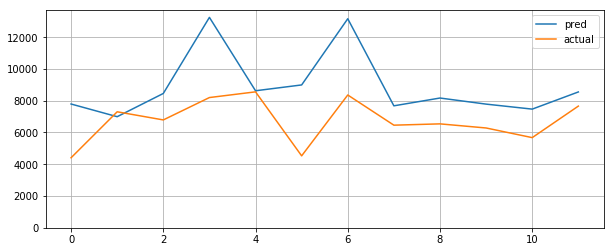

In [322]:
plt.plot(preds, label='pred')
plt.plot(y_test.tolist(), label='actual')
plt.ylim(ymin=0)
plt.legend()
plt.grid()
pp(mean_absolute_error(preds, y_test)/(np.ptp(y)))

In [191]:
pp(y_test.head())
y_test.shift(1).head()

Year  Month
2015  5        1066
      6         881
      7         941
      8         847
      9        1001
Name: Value, dtype: int32


Year  Month
2015  5           NaN
      6        1066.0
      7         881.0
      8         941.0
      9         847.0
Name: Value, dtype: float64

C:\Users\work-02\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


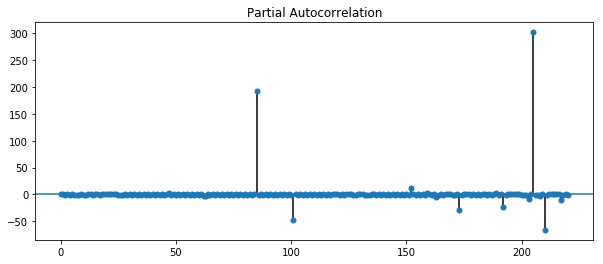

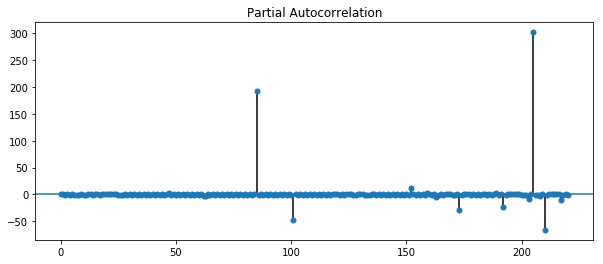

In [286]:
## Informed
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data[2].Value)